In [9]:
from openpyxl import load_workbook
import pandas as pd
import numpy as np
%matplotlib inline 
import datetime
from distance_functions import get_distance
from matplotlib import pyplot as plt
from math import sqrt
plt.style.use('classic')
plt.rcParams["figure.figsize"] = (10,10)

In [16]:



path = r'C:\Users\cambo\Documents\repos\python\work\Complex\ASN_ISC_2012-2023_Gakkel.xlsx'
class Tab_clusters():
    def load_catalog(self):
        wb = load_workbook(path)
        self.data = pd.read_excel(path)
        self.latitudes = self.data['Lat']
        self.longitudes = self.data['Lon']

        self.dates =  self.data['Date']
        self.times =  self.data['Origin time']
        self.N = len(self.longitudes)

    def get_distances_matrix(self):
        self.distances_matrix = np.zeros((self.N,self.N))
        for i in range(self.N):
            
            for j in range(self.N):
                self.distances_matrix[i,j] = get_distance(self.latitudes[i], self.longitudes[i], self.latitudes[j],self.longitudes[j])

    def get_time_diff_matrix(self):
        
        datetime_string = [str(self.dates[i])[:10]+';'+str(self.times[i]) for i in range(self.N)]
        self.datetimes = np.array([datetime.datetime.strptime(datetime_string[i], "%Y-%m-%d;%H:%M:%S.%f") for i in range(self.N)])
        self.time_diff_matrix = np.zeros((self.N,self.N),dtype=datetime.timedelta)
        for i in range(self.N):
            for j in range(self.N):
                td = self.datetimes[j]-self.datetimes[i]
                self.time_diff_matrix[i,j] = td.total_seconds()/3600/24
        

    def get_dst_matrix(self):
        C=1
        self.dst_matrix = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                self.dst_matrix[i,j] = sqrt(self.distances_matrix[i,j]**2+C**2*self.time_diff_matrix[i,j]**2)

    def plot(self):
        plt.scatter(self.longitudes, self.dates)
        # plt.show()

    def get_minimum_dst(self):
        
        np.fill_diagonal(self.dst_matrix,float('inf')) # чтобы не выбирал сам себя ближайшим соседом
        self.minimum_dst = np.min(self.dst_matrix,1)

    def get_D(self):
        S1 = np.median(self.minimum_dst)
        self.D = 9.4 * sqrt(S1) - 25.2

    def get_if_clustered_matrix(self):
        self.if_clustered_matrix = np.empty((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                self.if_clustered_matrix[i,j] = True if self.dst_matrix[i,j] < self.D else False

    def get_clusters(self):
        def find_cluster(id,ids_in_that_cluster):

            ids_in_that_cluster.append(id) # he himself is in his cluster
            
        
            neighbour_ids = set(np.where(self.if_clustered_matrix[id] == 1)[0])
            
            global not_watched
            not_watched.update(  set(neighbour_ids) -  set(ids_in_that_cluster) ) # в непросмотренные добавляем обнаруженных соседей - те которые уже посмотрели (ids in that cluster)
            not_watched.discard(id)
            
            for cur_id in not_watched & neighbour_ids: 
                if cur_id in not_watched: # костыль из-за смены not_watched. Доп проверка чтобы избежать повторного захода туда где уже были
                    find_cluster(cur_id,ids_in_that_cluster)
            
            if len(not_watched)==0:
                return ids_in_that_cluster

        self.Clusters = []
        ids_not_clustered = list(range(0,self.N))
        
        while len(ids_not_clustered)!=0:
            global not_watched
            not_watched =  set()
            cur_id_to_find_cluster_of = ids_not_clustered[0]
            
            cluster_ids = find_cluster(cur_id_to_find_cluster_of, [])
        

            for id in cluster_ids:
                ids_not_clustered.remove(id)
            self.Clusters.append(cluster_ids)

    def year_fraction(self, date):
        start = datetime.date(date.year, 1, 1).toordinal()
        year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
        return date.year + float(date.toordinal() - start) / year_length
    
    def plot_clusters(self):
        min_len_of_swarm = 8
        ids_of_swarms = []
        ids_not_swarms = []
        for i in range(len(self.Clusters)):
            if len(self.Clusters[i]) > min_len_of_swarm:
                ids_of_swarms.extend(self.Clusters[i])
            else:
                ids_not_swarms.extend(self.Clusters[i])

        print(self.datetimes[ids_of_swarms])
        Year_fractions_swarms = [self.year_fraction(my_datetime) for my_datetime in self.datetimes[ids_of_swarms] ]
        Year_fractions_not_swarms = [self.year_fraction(my_datetime) for my_datetime in self.datetimes[ids_not_swarms] ]
        
        plt.scatter(self.longitudes[ids_of_swarms], Year_fractions_swarms, color='red')
        plt.scatter(self.longitudes[ids_not_swarms], Year_fractions_not_swarms, color='blue')
        plt.grid()
        plt.yticks(np.arange(min(self.dates).year, max(self.dates).year+2,1))
        plt.show()

        



In [19]:
Example = Tab_clusters()
Example.load_catalog()
Example.get_distances_matrix()
Example.get_time_diff_matrix()
Example.get_dst_matrix()
Example.get_minimum_dst()
Example.get_D()
Example.get_if_clustered_matrix()
Example.get_clusters()
Example.plot()



[datetime.datetime(2012, 4, 19, 1, 41, 39)
 datetime.datetime(2012, 4, 29, 11, 1, 7)
 datetime.datetime(2012, 4, 29, 11, 40, 47)
 datetime.datetime(2012, 4, 30, 6, 16, 25)
 datetime.datetime(2012, 4, 29, 15, 9, 53)
 datetime.datetime(2012, 4, 29, 16, 29, 56, 440000)
 datetime.datetime(2012, 4, 29, 11, 29, 52, 700000)
 datetime.datetime(2012, 4, 29, 11, 33, 8, 250000)
 datetime.datetime(2012, 5, 1, 4, 45, 30, 40000)
 datetime.datetime(2012, 4, 30, 8, 25, 52, 660000)
 datetime.datetime(2012, 4, 19, 1, 41, 32, 940000)
 datetime.datetime(2012, 4, 30, 11, 34, 56, 640000)
 datetime.datetime(2012, 4, 30, 8, 25, 55)
 datetime.datetime(2012, 4, 30, 8, 25, 56)
 datetime.datetime(2012, 4, 30, 11, 35, 5)
 datetime.datetime(2012, 4, 29, 21, 51, 40)
 datetime.datetime(2012, 4, 29, 22, 15, 45)
 datetime.datetime(2012, 4, 29, 11, 33, 11)
 datetime.datetime(2012, 5, 1, 1, 34, 47)
 datetime.datetime(2012, 4, 29, 14, 34, 44)
 datetime.datetime(2016, 3, 1, 11, 58, 12)
 datetime.datetime(2016, 3, 4, 1, 8, 

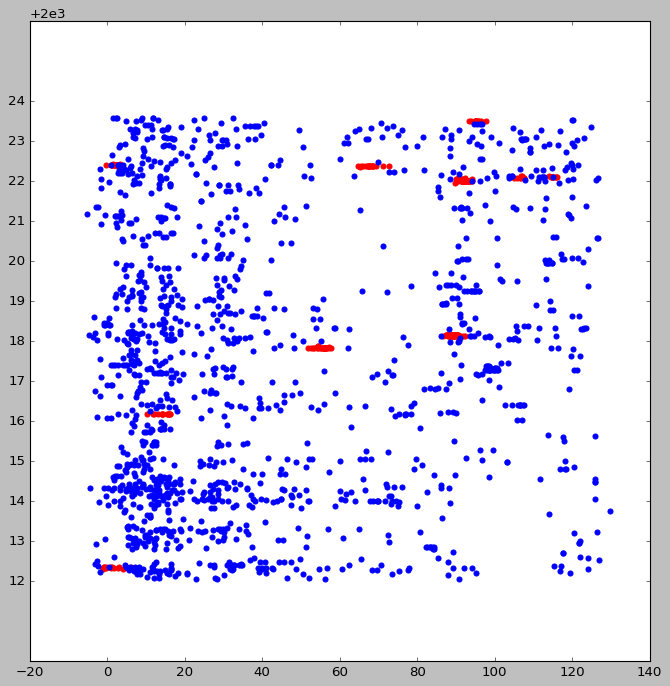

In [18]:
Example.plot_clusters()

In [78]:
def year_fraction(date):
        start = datetime.date(date.year, 1, 1).toordinal()
        year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
        return date.year + float(date.toordinal() - start) / year_length


[2012.032786885246, 2012.032786885246, 2012.032786885246]